## Importing the libraries

In [1]:
## Pandas and Numpy

import pandas as pd
import numpy as np

## For directory operations

import os

## OpenCV

import cv2

## Tensorflow and Keras + Utils

import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, InputLayer, Flatten, Dropout, MaxPooling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

## Matplotlib for visualizing

from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
## Turning off warnings

import warnings
warnings.filterwarnings("ignore")

In [3]:
## Fixing random seed

import random
random.seed(0)

## Loading the Data

In [4]:
## Training Set

training_dataset = tensorflow.keras.preprocessing.image_dataset_from_directory('C:\\Users\\Kunal\\Learning\\GreatLearning\\9 Computer Vision\\Assignment1\\plant-seedlings-classification\\train', image_size=(64, 64), batch_size=4750, validation_split=0.1, subset="training", shuffle=True, seed=0)

## Validation Set

validation_dataset = tensorflow.keras.preprocessing.image_dataset_from_directory('C:\\Users\\Kunal\\Learning\\GreatLearning\\9 Computer Vision\\Assignment1\\plant-seedlings-classification\\train', image_size=(64, 64), batch_size=4750, validation_split=0.1, subset="validation", shuffle=True, seed=0)


Found 4750 files belonging to 12 classes.
Using 4275 files for training.
Found 4750 files belonging to 12 classes.
Using 475 files for validation.


In [5]:
## Looping over data batches

## Also checking the dimensions of the data

for X_train, y_train in training_dataset.take(1):
  print(X_train.shape)
  print(y_train.shape)
for X_val, y_val in validation_dataset.take(1):
  print(X_val.shape)
  print(y_val.shape)

(4275, 64, 64, 3)
(4275,)
(475, 64, 64, 3)
(475,)


In [6]:
# Converting data into numpy arrays and int type 

X_train = X_train.numpy().astype("uint8")
y_train = y_train.numpy().astype("uint8")

X_val = X_val.numpy().astype("uint8")
y_val = y_val.numpy().astype("uint8")

## Visualizing the images

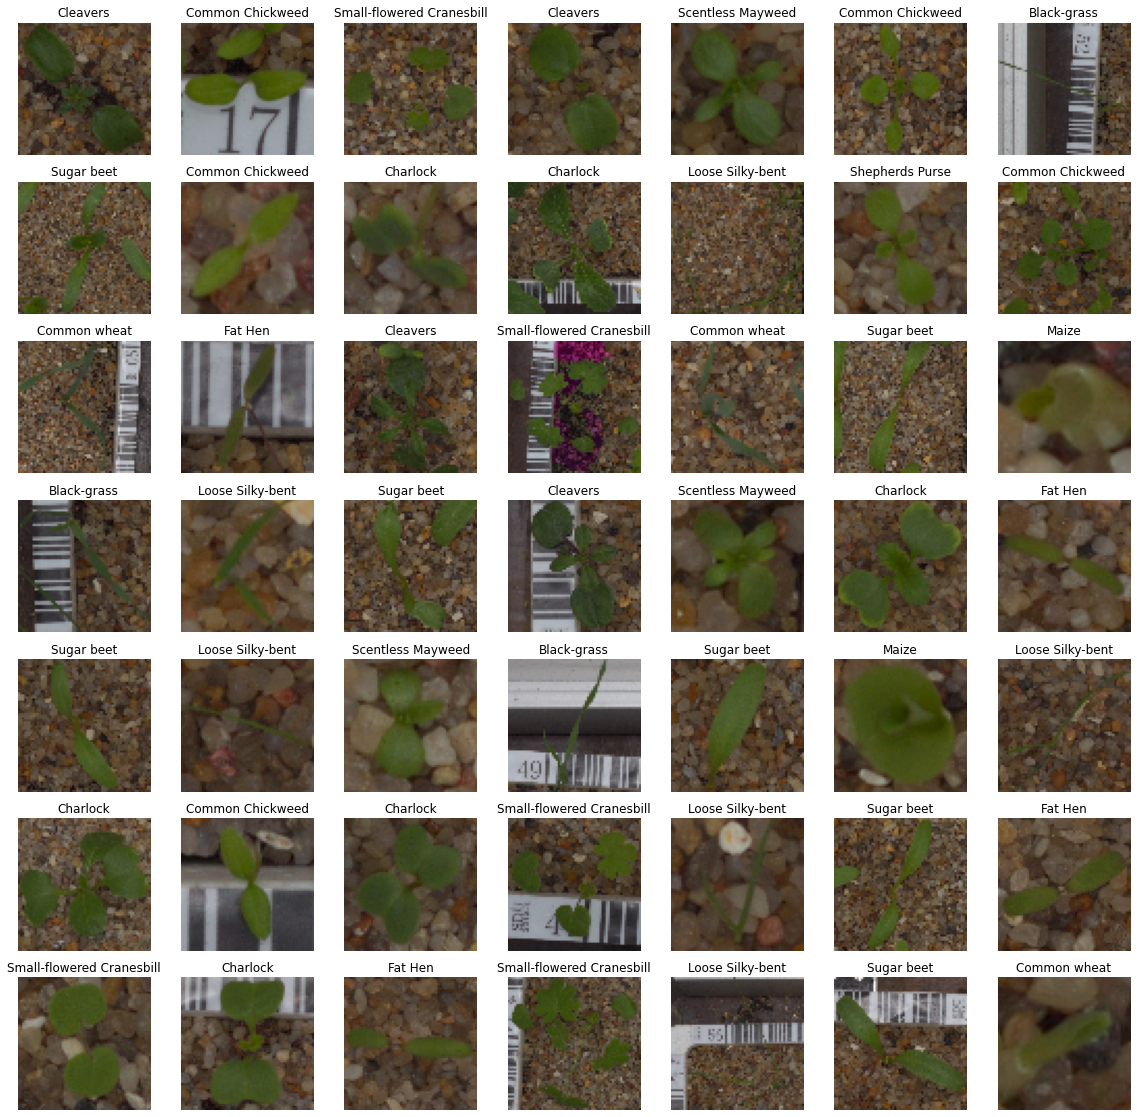

In [7]:
classnames = training_dataset.class_names
#X_train_viz = X_train.reshape(X_train.shape[0],64,64)
plt.figure(figsize=(20, 20))
for i in range(49):
  ax = plt.subplot(7, 7, i+1)
  plt.imshow(X_train[i])
  plt.title(classnames[y_train[i]])
  plt.axis("off")

In [8]:
## Normalize data

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

X_train = X_train/255
X_val = X_val/255

In [9]:
## Flattening the array to one dimensional for Supervised Learning Models

X_train_flat = X_train.reshape(X_train.shape[0],12288)
X_val_flat = X_val.reshape(X_val.shape[0],12288)

## Supervised Learning Models

### 1. Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=200, random_state=1)
model_rf.fit(X_train_flat,y_train)
print(round(model_rf.score(X_val_flat,y_val),3))

0.558


### 2. XGBoost

In [11]:
from xgboost import XGBClassifier
model_xgb = XGBClassifier(random_state = 42)
model_xgb.fit(X_train_flat,y_train)
print(round(model_xgb.score(X_val_flat,y_val),3))

[19:37:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.623


### 3. Support Vector Machine

In [12]:
from sklearn.svm import SVC
model_svc = SVC(gamma = 0.1, C = 1, kernel = 'rbf')
model_svc.fit(X_train_flat,y_train)
print(round(model_svc.score(X_val_flat,y_val),3))

0.154


##### We see that the XGBoost Model works best amongst the supervised learning models. Model tuning using RandomSearchCV is highly time consuming for the SL models and therefore not shown in this notebook. As an experiment it was tried and even after 3 hours of running on colab GPU, code run could not be completed. Therefore it was interrupted and tuning was dropped. The code is in the markdown below

## Params Grid

params_xgb = {
    "colsample_bytree": [round(x,2) for x in np.linspace(.1,1,num=5)],
    "gamma": [round(x,2) for x in np.linspace(.1,0.5,num=5)],
    "learning_rate": [round(x,2) for x in np.linspace(0.03,0.3,num=5)], # default 0.1 
    "max_depth": [int(x) for x in np.linspace(start = 2, stop = 6, num = 5)], # default 3
    "n_estimators": [int(x) for x in np.linspace(start = 200, stop = 800, num = 7)], # default 100
    "subsample": [x for x in np.linspace(.5,1,num=6)]
}

## Using Random Search CV to find best params in the given param space

from sklearn.model_selection import RandomizedSearchCV
model_xgb2 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1,
              importance_type='gain', interaction_constraints='',
              max_delta_step=0,
              min_child_weight=1, 
              n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              tree_method='exact', validate_parameters=1, verbosity=2)

XGB_random = RandomizedSearchCV(estimator = model_xgb2, param_distributions = params_xgb, n_iter = 50, cv = 3, random_state=42, n_jobs = -1, verbose=2)

XGB_random.fit(X_train_flat,y_train)

## Building a Neural Networks Model

In [22]:
categorical_values = []

for i in range(len(y_train)):
    categorical_values.append(str(y_train[i])+"-"+classnames[y_train[i]])
    

In [24]:
category_values = np.unique(categorical_values)

In [25]:
category_values

array(['0-Black-grass', '1-Charlock', '10-Small-flowered Cranesbill',
       '11-Sugar beet', '2-Cleavers', '3-Common Chickweed',
       '4-Common wheat', '5-Fat Hen', '6-Loose Silky-bent', '7-Maize',
       '8-Scentless Mayweed', '9-Shepherds Purse'], dtype='<U28')

In [26]:
# One hot encode y vector

from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes = 12)
y_val = to_categorical(y_val, num_classes = 12)

In [27]:
from tensorflow.keras import regularizers, optimizers

def train_and_val_loop(iterations = 10, lr = 0.001, Lambda = 1e-7, verb = True):

  ## hyperparamters
  iterations = iterations
  learning_rate = lr
  hidden_nodes = 256
  output_nodes = 12

  model_nn = Sequential()
  model_nn.add(Dense(hidden_nodes, input_shape = (12288,), activation = 'relu'))
  model_nn.add(Dense(hidden_nodes, activation = 'relu'))
  model_nn.add(Dense(output_nodes, activation = 'softmax', kernel_regularizer = regularizers.l2(Lambda)))
  
  sgd = optimizers.SGD(lr = learning_rate, decay = 1e-6, momentum = 0.9)

  # Compile Model

  model_nn.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])

  # Fit the model
  
  model_nn.fit(X_train_flat, y_train, epochs = iterations, batch_size = 1000, verbose = 1, validation_data = (X_val_flat, y_val))
  score = model_nn.evaluate(X_val_flat, y_val, verbose = 0)

  return score


In [28]:
## First model with initial params

train_and_val_loop()

Epoch 1/10
5/5 [==============================] - 1s 183ms/step - loss: 2.4632 - accuracy: 0.0966 - val_loss: 2.4511 - val_accuracy: 0.1284
Epoch 2/10
5/5 [==============================] - 1s 118ms/step - loss: 2.4240 - accuracy: 0.1498 - val_loss: 2.4332 - val_accuracy: 0.1158
Epoch 3/10
5/5 [==============================] - 1s 104ms/step - loss: 2.4109 - accuracy: 0.1513 - val_loss: 2.4270 - val_accuracy: 0.1432
Epoch 4/10
5/5 [==============================] - 1s 115ms/step - loss: 2.4033 - accuracy: 0.1595 - val_loss: 2.4205 - val_accuracy: 0.1516
Epoch 5/10
5/5 [==============================] - 1s 115ms/step - loss: 2.4037 - accuracy: 0.1609 - val_loss: 2.4150 - val_accuracy: 0.1474
Epoch 6/10
5/5 [==============================] - 1s 114ms/step - loss: 2.3962 - accuracy: 0.1771 - val_loss: 2.4104 - val_accuracy: 0.1642
Epoch 7/10
5/5 [==============================] - 1s 102ms/step - loss: 2.3896 - accuracy: 0.1845 - val_loss: 2.4081 - val_accuracy: 0.1474
Epoch 8/10
5/5 [====

[2.38893985748291, 0.20210526883602142]

In [29]:
## Second model with changed params

train_and_val_loop(iterations = 100, lr = 0.01, Lambda = 1e-7, verb = True)

Epoch 1/100
5/5 [==============================] - 1s 158ms/step - loss: 2.5201 - accuracy: 0.0791 - val_loss: 2.4282 - val_accuracy: 0.1411
Epoch 2/100
5/5 [==============================] - 1s 109ms/step - loss: 2.4139 - accuracy: 0.1436 - val_loss: 2.4279 - val_accuracy: 0.1474
Epoch 3/100
5/5 [==============================] - 1s 108ms/step - loss: 2.3920 - accuracy: 0.1681 - val_loss: 2.3940 - val_accuracy: 0.1537
Epoch 4/100
5/5 [==============================] - 1s 109ms/step - loss: 2.3728 - accuracy: 0.1705 - val_loss: 2.3614 - val_accuracy: 0.1537
Epoch 5/100
5/5 [==============================] - 1s 110ms/step - loss: 2.3497 - accuracy: 0.1678 - val_loss: 2.3362 - val_accuracy: 0.2084
Epoch 6/100
5/5 [==============================] - 1s 116ms/step - loss: 2.3164 - accuracy: 0.2308 - val_loss: 2.2985 - val_accuracy: 0.2295
Epoch 7/100
5/5 [==============================] - 1s 168ms/step - loss: 2.2849 - accuracy: 0.2522 - val_loss: 2.2613 - val_accuracy: 0.2589
Epoch 8/100
5

Epoch 59/100
5/5 [==============================] - 1s 129ms/step - loss: 1.6730 - accuracy: 0.4439 - val_loss: 1.7643 - val_accuracy: 0.3432
Epoch 60/100
5/5 [==============================] - 1s 107ms/step - loss: 1.4508 - accuracy: 0.4929 - val_loss: 1.6568 - val_accuracy: 0.3832
Epoch 61/100
5/5 [==============================] - 1s 120ms/step - loss: 1.3404 - accuracy: 0.5392 - val_loss: 1.7276 - val_accuracy: 0.3916
Epoch 62/100
5/5 [==============================] - 1s 106ms/step - loss: 1.4307 - accuracy: 0.5086 - val_loss: 2.4664 - val_accuracy: 0.2947
Epoch 63/100
5/5 [==============================] - 1s 111ms/step - loss: 2.1438 - accuracy: 0.3335 - val_loss: 2.2172 - val_accuracy: 0.3137
Epoch 64/100
5/5 [==============================] - 1s 112ms/step - loss: 1.9322 - accuracy: 0.3566 - val_loss: 2.0523 - val_accuracy: 0.3221
Epoch 65/100
5/5 [==============================] - 1s 112ms/step - loss: 1.7988 - accuracy: 0.4082 - val_loss: 1.7486 - val_accuracy: 0.3642
Epoch 

[1.5908987522125244, 0.42105263471603394]

In [30]:
## Third Model

train_and_val_loop(iterations = 100, lr = 0.1, Lambda = 1e-7, verb = True)

Epoch 1/100
5/5 [==============================] - 1s 131ms/step - loss: 2.5714 - accuracy: 0.0920 - val_loss: 3.0368 - val_accuracy: 0.0484
Epoch 2/100
5/5 [==============================] - 1s 112ms/step - loss: 2.8593 - accuracy: 0.0977 - val_loss: 2.4349 - val_accuracy: 0.1453
Epoch 3/100
5/5 [==============================] - 1s 101ms/step - loss: 2.4309 - accuracy: 0.1536 - val_loss: 2.4300 - val_accuracy: 0.1137
Epoch 4/100
5/5 [==============================] - 1s 107ms/step - loss: 2.4109 - accuracy: 0.1308 - val_loss: 2.3994 - val_accuracy: 0.1895
Epoch 5/100
5/5 [==============================] - 1s 102ms/step - loss: 2.3899 - accuracy: 0.1713 - val_loss: 2.3987 - val_accuracy: 0.1368
Epoch 6/100
5/5 [==============================] - 1s 104ms/step - loss: 2.3577 - accuracy: 0.1659 - val_loss: 2.5067 - val_accuracy: 0.1137
Epoch 7/100
5/5 [==============================] - 1s 103ms/step - loss: 2.4461 - accuracy: 0.1676 - val_loss: 2.4232 - val_accuracy: 0.2000
Epoch 8/100
5

Epoch 59/100
5/5 [==============================] - 0s 103ms/step - loss: 2.4145 - accuracy: 0.1347 - val_loss: 2.4335 - val_accuracy: 0.1453
Epoch 60/100
5/5 [==============================] - 0s 93ms/step - loss: 2.4134 - accuracy: 0.1419 - val_loss: 2.4333 - val_accuracy: 0.1453
Epoch 61/100
5/5 [==============================] - 1s 116ms/step - loss: 2.4145 - accuracy: 0.1402 - val_loss: 2.4329 - val_accuracy: 0.1453
Epoch 62/100
5/5 [==============================] - 1s 106ms/step - loss: 2.4151 - accuracy: 0.1334 - val_loss: 2.4326 - val_accuracy: 0.1453
Epoch 63/100
5/5 [==============================] - 1s 112ms/step - loss: 2.4130 - accuracy: 0.1419 - val_loss: 2.4325 - val_accuracy: 0.1453
Epoch 64/100
5/5 [==============================] - 1s 114ms/step - loss: 2.4111 - accuracy: 0.1394 - val_loss: 2.4323 - val_accuracy: 0.1453
Epoch 65/100
5/5 [==============================] - 0s 97ms/step - loss: 2.4133 - accuracy: 0.1386 - val_loss: 2.4323 - val_accuracy: 0.1453
Epoch 66

[2.4329745769500732, 0.1452631652355194]

In [31]:
## Trying a new model with changes in neurons, number of layers and optimizer


def train_and_val_loop2(iterations = 50, lr = 0.0001, Lambda = 1e-7, verb = True):

  ## hyperparamters
  iterations = iterations
  learning_rate = lr
  hidden_nodes = 4096
  output_nodes = 12

  model_nn2 = Sequential()
  model_nn2.add(Dense(hidden_nodes, input_shape = (12288,), activation = 'relu'))
  model_nn2.add(Dense(hidden_nodes/2, activation = 'relu'))
  model_nn2.add(Dense(hidden_nodes/4, activation = 'relu'))  
  model_nn2.add(Dense(output_nodes, activation = 'softmax', kernel_regularizer = regularizers.l2(Lambda)))
  
  adam = optimizers.Adam(lr = learning_rate)

  # Compile Model

  model_nn2.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

  # Fit the model
  
  model_nn2.fit(X_train_flat, y_train, epochs = iterations, batch_size = 1000, verbose = 1, validation_data = (X_val_flat, y_val))
  score = model_nn2.evaluate(X_val_flat, y_val, verbose = 0)

  return score

In [32]:
train_and_val_loop2()

Epoch 1/50
5/5 [==============================] - 9s 2s/step - loss: 2.6024 - accuracy: 0.1143 - val_loss: 2.4366 - val_accuracy: 0.1453
Epoch 2/50
5/5 [==============================] - 7s 1s/step - loss: 2.4192 - accuracy: 0.1629 - val_loss: 2.4138 - val_accuracy: 0.1095
Epoch 3/50
5/5 [==============================] - 8s 2s/step - loss: 2.3806 - accuracy: 0.1659 - val_loss: 2.3623 - val_accuracy: 0.1347
Epoch 4/50
5/5 [==============================] - 8s 1s/step - loss: 2.3175 - accuracy: 0.2099 - val_loss: 2.2849 - val_accuracy: 0.1937
Epoch 5/50
5/5 [==============================] - 7s 1s/step - loss: 2.2446 - accuracy: 0.2436 - val_loss: 2.2843 - val_accuracy: 0.1811
Epoch 6/50
5/5 [==============================] - 8s 1s/step - loss: 2.2277 - accuracy: 0.2092 - val_loss: 2.2045 - val_accuracy: 0.2400
Epoch 7/50
5/5 [==============================] - 8s 1s/step - loss: 2.1746 - accuracy: 0.2724 - val_loss: 2.1667 - val_accuracy: 0.1979
Epoch 8/50
5/5 [=========================

[1.4446747303009033, 0.5073684453964233]

In [33]:
train_and_val_loop2(iterations=100)

Epoch 1/100
5/5 [==============================] - 9s 2s/step - loss: 2.6830 - accuracy: 0.1072 - val_loss: 2.4744 - val_accuracy: 0.1495
Epoch 2/100
5/5 [==============================] - 8s 2s/step - loss: 2.4283 - accuracy: 0.1427 - val_loss: 2.4162 - val_accuracy: 0.0863
Epoch 3/100
5/5 [==============================] - 8s 2s/step - loss: 2.3930 - accuracy: 0.1496 - val_loss: 2.4177 - val_accuracy: 0.1368
Epoch 4/100
5/5 [==============================] - 8s 2s/step - loss: 2.3582 - accuracy: 0.1766 - val_loss: 2.3395 - val_accuracy: 0.1516
Epoch 5/100
5/5 [==============================] - 8s 2s/step - loss: 2.2980 - accuracy: 0.1797 - val_loss: 2.2713 - val_accuracy: 0.2253
Epoch 6/100
5/5 [==============================] - 7s 1s/step - loss: 2.2541 - accuracy: 0.2243 - val_loss: 2.2235 - val_accuracy: 0.2400
Epoch 7/100
5/5 [==============================] - 8s 2s/step - loss: 2.1950 - accuracy: 0.2569 - val_loss: 2.2092 - val_accuracy: 0.2042
Epoch 8/100
5/5 [=================

Epoch 60/100
5/5 [==============================] - 8s 2s/step - loss: 0.9781 - accuracy: 0.6721 - val_loss: 1.3979 - val_accuracy: 0.5137
Epoch 61/100
5/5 [==============================] - 8s 2s/step - loss: 0.9619 - accuracy: 0.6754 - val_loss: 1.6141 - val_accuracy: 0.4568
Epoch 62/100
5/5 [==============================] - 8s 2s/step - loss: 1.0162 - accuracy: 0.6483 - val_loss: 1.6478 - val_accuracy: 0.4316
Epoch 63/100
5/5 [==============================] - 8s 2s/step - loss: 1.0897 - accuracy: 0.6170 - val_loss: 1.4872 - val_accuracy: 0.5032
Epoch 64/100
5/5 [==============================] - 10s 2s/step - loss: 0.9721 - accuracy: 0.6714 - val_loss: 1.4480 - val_accuracy: 0.5053
Epoch 65/100
5/5 [==============================] - 9s 2s/step - loss: 0.9359 - accuracy: 0.6882 - val_loss: 1.3764 - val_accuracy: 0.5368
Epoch 66/100
5/5 [==============================] - 9s 2s/step - loss: 0.8785 - accuracy: 0.7183 - val_loss: 1.3934 - val_accuracy: 0.5221
Epoch 67/100
5/5 [========

[1.3766412734985352, 0.5494737029075623]

We see that NN models with Fully connected layers also do not perform well. In fact they perform worse than XGBoost models

## Now trying CNNs

In [115]:
## CNN Model building

model_cnn = Sequential()
model_cnn.add(Conv2D(filters = 32, kernel_size = 3, activation = 'relu', input_shape = (64,64,3)))
model_cnn.add(Conv2D(filters = 64, kernel_size = 3, activation = 'relu'))
model_cnn.add(MaxPooling2D(pool_size = (2,2)))
model_cnn.add(Dropout(rate = 0.2))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation = 'relu'))
model_cnn.add(Dense(12, activation = 'softmax'))

In [35]:
## Compiling the model

model_cnn.compile(loss = 'categorical_crossentropy', metrics = ["accuracy"], optimizer = "adam")

In [36]:
model_cnn.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val,y_val))

Epoch 1/10
134/134 [==============================] - 35s 256ms/step - loss: 2.3908 - accuracy: 0.2111 - val_loss: 1.6212 - val_accuracy: 0.3832
Epoch 2/10
134/134 [==============================] - 33s 245ms/step - loss: 1.4576 - accuracy: 0.4919 - val_loss: 1.3120 - val_accuracy: 0.5179
Epoch 3/10
134/134 [==============================] - 33s 248ms/step - loss: 1.0351 - accuracy: 0.6502 - val_loss: 1.3096 - val_accuracy: 0.5768
Epoch 4/10
134/134 [==============================] - 34s 255ms/step - loss: 0.7455 - accuracy: 0.7684 - val_loss: 1.0587 - val_accuracy: 0.6421
Epoch 5/10
134/134 [==============================] - 34s 257ms/step - loss: 0.5395 - accuracy: 0.8410 - val_loss: 1.1472 - val_accuracy: 0.6463
Epoch 6/10
134/134 [==============================] - 34s 256ms/step - loss: 0.3714 - accuracy: 0.8913 - val_loss: 1.1624 - val_accuracy: 0.6632
Epoch 7/10
134/134 [==============================] - 33s 250ms/step - loss: 0.2134 - accuracy: 0.9465 - val_loss: 1.1483 - val_ac

### We see that with a simple CNN accuracy went upto 68%

## Transfer Learning - VGG net

In [37]:
# example of loading the vgg16 model
from tensorflow.keras.applications.vgg16 import VGG16
# load model
model_vggtl = VGG16()
# summarize the model
model_vggtl.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [39]:
model_vggtl = VGG16(include_top=False, input_shape=(64, 64, 3))

# add new classifier layers
dropout1 = Dropout(rate = 0.2)(model_vggtl.layers[-1].output)
flat1 = Flatten()(dropout1)
class1 = Dense(4096, activation='relu')(flat1)
class2 = Dense(4096, activation = 'relu')(class1)
output = Dense(12, activation='softmax')(class2)

# define new model

model_vggtl = Model(inputs=model_vggtl.inputs, outputs=output)
# summarize

model_vggtl.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [40]:
# Make only dense layers trainable

for layers in model_vggtl.layers:
  if ('dense' not in layers.name):
    layers.trainable = False
  if ('dense' in layers.name):
    print(layers.name + ' is trained')


dense_22 is trained
dense_23 is trained
dense_24 is trained


In [41]:
# compile model
model_vggtl.compile(loss = 'categorical_crossentropy', metrics = ["accuracy"], optimizer = "adam")

In [42]:
callback = tensorflow.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience=2, min_delta=0.01)

model_vggtl.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val,y_val))

Epoch 1/20
134/134 [==============================] - 90s 665ms/step - loss: 2.9026 - accuracy: 0.2485 - val_loss: 1.5152 - val_accuracy: 0.4632
Epoch 2/20
134/134 [==============================] - 86s 643ms/step - loss: 1.4112 - accuracy: 0.4924 - val_loss: 1.3120 - val_accuracy: 0.5579
Epoch 3/20
134/134 [==============================] - 90s 675ms/step - loss: 1.2460 - accuracy: 0.5511 - val_loss: 1.2500 - val_accuracy: 0.5747
Epoch 4/20
134/134 [==============================] - 90s 674ms/step - loss: 1.1249 - accuracy: 0.5933 - val_loss: 1.2398 - val_accuracy: 0.5600
Epoch 5/20
134/134 [==============================] - 93s 693ms/step - loss: 1.0935 - accuracy: 0.6074 - val_loss: 1.1798 - val_accuracy: 0.6021
Epoch 6/20
134/134 [==============================] - 88s 657ms/step - loss: 0.9733 - accuracy: 0.6532 - val_loss: 1.2301 - val_accuracy: 0.5895
Epoch 7/20
134/134 [==============================] - 93s 696ms/step - loss: 0.9350 - accuracy: 0.6606 - val_loss: 1.1973 - val_ac

## Observations

While we will talk about the various algorithms used I just want to highlight that the above exercise included multiple experiments apart from the experiments with different algorithms.

1. Using images in a single channel grayscale mode and then in 3 channel rgb mode - the results were significantly better in the color (3 channels rgb mode) from model accuracy of NN hovering around 0.19 the accuracy score jumped to 0.45


2. Size of images - various sizes were tried like 28X28, 32X32, 128X128. Finally 64X64 image size was chosen. The model accuracies were poor for small sized images and for large size images the computation time was too much


3. Model Tuning - Model Tuning for SL methods was tried, but it took extremely long and therefore it was dropped.

### Observations on algorithms:

1. Various algorithms were tried
    a. Random Forest Classifier
    
    b. XGBoost Classifier - XGBoost classifier worked the best amongst Supervised Learning Methods tried
    
    c. Support Vector Machines - SVM performed quite badly
    
    d. Tuned Fully Connected NN - final result was better than SVM but worse than RF and XGBoost Models
    
    e. Simple CNN with 2 Conv layers and two dense layers - Performed the best. Brought Accuracy to almost 72% in one of the runs
    
    f. Transfer learning model using VGG Net - Ideally should have performed the best, but accuracy reached upto a maximum of 67% in one of the runs. Adding dropout layer increase accuracy.
 
 
2. Supervised Learning methods perform better than Fully Connected Neural Nets because the training data is not enough for the NN only 4275 images for 12 classes.


3. 7 layer CNN performs better than FC neural net since as the two conv layers do feature extraction to identify details of the images.


4. However, it is difficult to understand why transfer learning using VGG net didnt work as well as the 7 layer CNN


## Saving the model

In [65]:
model_cnn.save('FinalSeedlingClassifier') ## using model.save instead of pickling as pickling of NN is quite difficult

INFO:tensorflow:Assets written to: FinalSeedlingClassifier\assets


In [261]:
seedimg = plt.imread('C:\\Users\\Kunal\\Learning\\GreatLearning\\9 Computer Vision\\Assignment1\\plant-seedlings-classification\\Seedling - Prediction\\Predict.png')

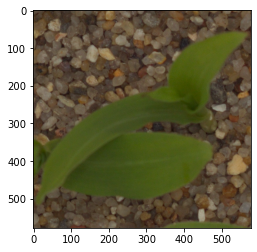

In [262]:
plt.imshow(seedimg)

In [263]:
seedimg.shape

(578, 578, 3)

In [264]:
seedimg.resize(64,64,3)

In [265]:
seedimg = seedimg.reshape(1,64,64,3)

In [266]:
model_cnn.predict(seedimg).argmax()

0

In [72]:
category_values

array(['0-Black-grass', '1-Charlock', '10-Small-flowered Cranesbill',
       '11-Sugar beet', '2-Cleavers', '3-Common Chickweed',
       '4-Common wheat', '5-Fat Hen', '6-Loose Silky-bent', '7-Maize',
       '8-Scentless Mayweed', '9-Shepherds Purse'], dtype='<U28')

### We see for all images the model tends to predict class 6. It is an indication that it is a case of imbalanced classes. 

### We need to check for imbalanced classes, balance it out and retry the two cnn based models


<AxesSubplot:ylabel='Count'>

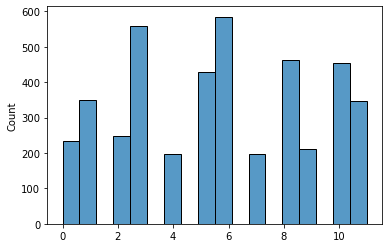

In [267]:
import seaborn as sns
y_train_values = []
for i in y_train:
    y_train_values.append(i.argmax())
sns.histplot(y_train_values)

### We see that the data is imbalanced

## Balancing the data

In [269]:
from tensorflow.keras.utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

In [270]:
datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip=True,
)


balanced_gen = BalancedDataGenerator(X_train, y_train, datagen, batch_size=32)
steps_per_epoch = balanced_gen.steps_per_epoch
tensorflow.config.run_functions_eagerly(True)

In [271]:
## CNN Model

model_cnn = Sequential()
model_cnn.add(Conv2D(filters = 32, kernel_size = 3, activation = 'relu', input_shape = (64,64,3)))
model_cnn.add(Conv2D(filters = 64, kernel_size = 3, activation = 'relu'))
model_cnn.add(MaxPooling2D(pool_size = (2,2)))
model_cnn.add(Dropout(rate = 0.2))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation = 'relu'))
model_cnn.add(Dense(12, activation = 'softmax'))

In [272]:
## Compiling the CNN model

model_cnn.compile(loss = 'categorical_crossentropy', metrics = ["accuracy"], optimizer = "adam")
model_cnn.fit_generator(balanced_gen, steps_per_epoch, epochs=35, validation_data=(X_val,y_val))

Epoch 1/35
219/219 [==============================] - 77s 349ms/step - loss: 2.5300 - accuracy: 0.1567 - val_loss: 1.9312 - val_accuracy: 0.2442
Epoch 2/35
219/219 [==============================] - 77s 351ms/step - loss: 1.8505 - accuracy: 0.2797 - val_loss: 1.6906 - val_accuracy: 0.3537
Epoch 3/35
219/219 [==============================] - 79s 364ms/step - loss: 1.6963 - accuracy: 0.3564 - val_loss: 1.5672 - val_accuracy: 0.4442
Epoch 4/35
219/219 [==============================] - 77s 350ms/step - loss: 1.5344 - accuracy: 0.4063 - val_loss: 1.5312 - val_accuracy: 0.4358
Epoch 5/35
219/219 [==============================] - 78s 355ms/step - loss: 1.4315 - accuracy: 0.4584 - val_loss: 1.3702 - val_accuracy: 0.4926
Epoch 6/35
219/219 [==============================] - 77s 352ms/step - loss: 1.3629 - accuracy: 0.4826 - val_loss: 1.3433 - val_accuracy: 0.5368
Epoch 7/35
219/219 [==============================] - 76s 347ms/step - loss: 1.2701 - accuracy: 0.5221 - val_loss: 1.3124 - val_ac

In [273]:
model_cnn.fit_generator(balanced_gen, steps_per_epoch, epochs=15, validation_data=(X_val,y_val)) # Trained for a total of 50 epochs

Epoch 1/15
219/219 [==============================] - 73s 334ms/step - loss: 0.5492 - accuracy: 0.8055 - val_loss: 0.8880 - val_accuracy: 0.7032
Epoch 2/15
219/219 [==============================] - 73s 335ms/step - loss: 0.5318 - accuracy: 0.8068 - val_loss: 0.8518 - val_accuracy: 0.7179
Epoch 3/15
219/219 [==============================] - 74s 339ms/step - loss: 0.5301 - accuracy: 0.8098 - val_loss: 0.9069 - val_accuracy: 0.7053
Epoch 4/15
219/219 [==============================] - 74s 336ms/step - loss: 0.5017 - accuracy: 0.8210 - val_loss: 0.8787 - val_accuracy: 0.7116
Epoch 5/15
219/219 [==============================] - 76s 347ms/step - loss: 0.4800 - accuracy: 0.8236 - val_loss: 1.1138 - val_accuracy: 0.6800
Epoch 6/15
219/219 [==============================] - 74s 336ms/step - loss: 0.4863 - accuracy: 0.8277 - val_loss: 0.8474 - val_accuracy: 0.7200
Epoch 7/15
219/219 [==============================] - 74s 336ms/step - loss: 0.4597 - accuracy: 0.8326 - val_loss: 0.8293 - val_ac

In [274]:
## Making the vgg16 tl model

model_vggtl = VGG16(include_top=False, input_shape=(64, 64, 3))

# add new classifier layers
dropout1 = Dropout(rate = 0.2)(model_vggtl.layers[-1].output)
flat1 = Flatten()(dropout1)
class1 = Dense(4096, activation='relu')(flat1)
class2 = Dense(4096, activation = 'relu')(class1)
output = Dense(12, activation='softmax')(class2)

# define new model

model_vggtl = Model(inputs=model_vggtl.inputs, outputs=output)
# summarize

model_vggtl.summary()

# Making only dense layers trainable

for layers in model_vggtl.layers:
  if ('dense' not in layers.name):
    layers.trainable = False
  if ('dense' in layers.name):
    print(layers.name + ' is trained')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

In [275]:
# compile model
model_vggtl.compile(loss = 'categorical_crossentropy', metrics = ["accuracy"], optimizer = "adam")

# Fitting the model
model_vggtl.fit_generator(balanced_gen, steps_per_epoch, epochs=20, validation_data=(X_val,y_val))

Epoch 1/20
219/219 [==============================] - 610s 3s/step - loss: 2.6404 - accuracy: 0.2289 - val_loss: 1.5425 - val_accuracy: 0.4105
Epoch 2/20
219/219 [==============================] - 601s 3s/step - loss: 1.6071 - accuracy: 0.4069 - val_loss: 1.4438 - val_accuracy: 0.4526
Epoch 3/20
219/219 [==============================] - 600s 3s/step - loss: 1.4533 - accuracy: 0.4588 - val_loss: 1.3480 - val_accuracy: 0.4884
Epoch 4/20
219/219 [==============================] - 600s 3s/step - loss: 1.3886 - accuracy: 0.4788 - val_loss: 1.3651 - val_accuracy: 0.5053
Epoch 5/20
219/219 [==============================] - 603s 3s/step - loss: 1.3662 - accuracy: 0.4970 - val_loss: 1.3268 - val_accuracy: 0.5074
Epoch 6/20
219/219 [==============================] - 610s 3s/step - loss: 1.3093 - accuracy: 0.5121 - val_loss: 1.3166 - val_accuracy: 0.5326
Epoch 7/20
219/219 [==============================] - 597s 3s/step - loss: 1.2659 - accuracy: 0.5340 - val_loss: 1.3410 - val_accuracy: 0.5074

In [276]:
## Training the model for 10 more epochs (trained for 40 epochs. last cell got deleted by mistake)
model_vggtl.fit_generator(balanced_gen, steps_per_epoch, epochs=10, validation_data=(X_val,y_val))

Epoch 1/10
219/219 [==============================] - 661s 3s/step - loss: 1.0750 - accuracy: 0.5990 - val_loss: 1.1105 - val_accuracy: 0.5916
Epoch 2/10
219/219 [==============================] - 657s 3s/step - loss: 1.0839 - accuracy: 0.6082 - val_loss: 1.0846 - val_accuracy: 0.6126
Epoch 3/10
219/219 [==============================] - 648s 3s/step - loss: 1.0457 - accuracy: 0.6125 - val_loss: 1.2059 - val_accuracy: 0.5684
Epoch 4/10
219/219 [==============================] - 645s 3s/step - loss: 1.0527 - accuracy: 0.6078 - val_loss: 1.1400 - val_accuracy: 0.5895
Epoch 5/10
219/219 [==============================] - 639s 3s/step - loss: 1.0428 - accuracy: 0.6143 - val_loss: 1.0957 - val_accuracy: 0.6021
Epoch 6/10
219/219 [==============================] - 652s 3s/step - loss: 1.0422 - accuracy: 0.6135 - val_loss: 1.1333 - val_accuracy: 0.6000
Epoch 7/10
219/219 [==============================] - 640s 3s/step - loss: 1.0351 - accuracy: 0.6146 - val_loss: 1.0684 - val_accuracy: 0.6105

##### While the vgg16 tl model may have a validation accuracy of 62.5% and it may increase on further training. We will stop the training for now and use the cnn model which presently has a better validation accuracy of upto 74% 

In [298]:
## Saving the best model

model_cnn.save('FinalSeedlingClassifier') ## using model.save instead of pickling as pickling of NN is quite difficult

INFO:tensorflow:Assets written to: FinalSeedlingClassifier\assets


In [299]:
## Loading the image for prediction

seedimg = plt.imread('C:\\Users\\Kunal\\Learning\\GreatLearning\\9 Computer Vision\\Assignment1\\plant-seedlings-classification\\Seedling - Prediction\\Predict.png')

1

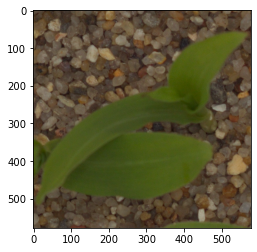

In [300]:

## showing the image

plt.imshow(seedimg)


## Resizing and reshaping the image
seedimg.resize(64,64,3)
seedimg = seedimg.reshape(1,64,64,3)

## Model prediction
model_cnn.predict(seedimg).argmax()

#### While the prediction is 1 - Charlock. It seems that the image may be of maize.

## In conclusion, the models need more training, especially the vgg16 model.


##### It is also important to note that the data was imbalanced and balancing the data with augmentation is important in such cases.